In [1]:
import numpyro
numpyro.enable_x64()
# numpyro.set_platform('gpu')

import jax
print(jax.devices())

import os
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value, init_to_sample, Trace_ELBO, TraceGraph_ELBO

from numpyro.infer.svi import SVI
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoLaplaceApproximation, AutoDAIS, AutoBNAFNormal, AutoIAFNormal, AutoMultivariateNormal
from numpyro.optim import Adam, ClippedAdam

import tensorflow_probability.substrates.jax as tfp

from jax import numpy as jnp
from jax import random, vmap

import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns

import siuba as s
from siuba import _

from plotnine import *

from matplotlib import pyplot as plt

import pickle

from lib.helpers import *
from lib.models import *

[CpuDevice(id=0)]


In [2]:
## Load Experiment 1 data
df1 = load_data_exp1() 
df1 = df1[~df1.querytype.str.contains('or')] # filtering as in avg analyses
df1 = (df1 >>
    s.arrange(_.ID) >>
    s.mutate(block = _.block-1) #>> 
      # s.mutate(estimate =  np.round(_.estimate*20).astype("int64"))
)

X_exp1, y_exp1 = make_model_data(df1)
print(len(y_exp1), "observations")


5664 observations


/Users/derekpowell/anaconda3/envs/bsampler/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='estimate', ylabel='Density'>

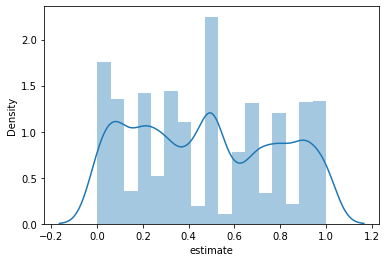

In [3]:
sns.distplot(df1.estimate)

In [4]:
## Load Experiment 2 data

df2 = (load_data_exp2_trials()  >> 
        s.filter(_.condition!=2) >>
      s.mutate(block = _.block-1) #>> 
      # s.mutate(estimate =  np.round(_.estimate*20).astype("int64"))
     )

X_exp2, y_exp2 = make_model_data(df2)
print(len(y_exp2), "observations")

10080 observations


/Users/derekpowell/anaconda3/envs/bsampler/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='estimate', ylabel='Density'>

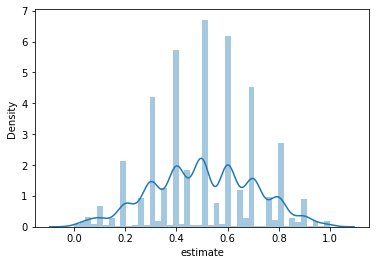

In [5]:
sns.distplot(df2.estimate)

In [6]:
model_exp1 = pickle.load(open("local/exp1/az_data_ptn_mlm_simplecond.p", "rb"))
model_exp2 = pickle.load(open("local/exp2/az_data_ptn_mlm_simplecond.p", "rb"))

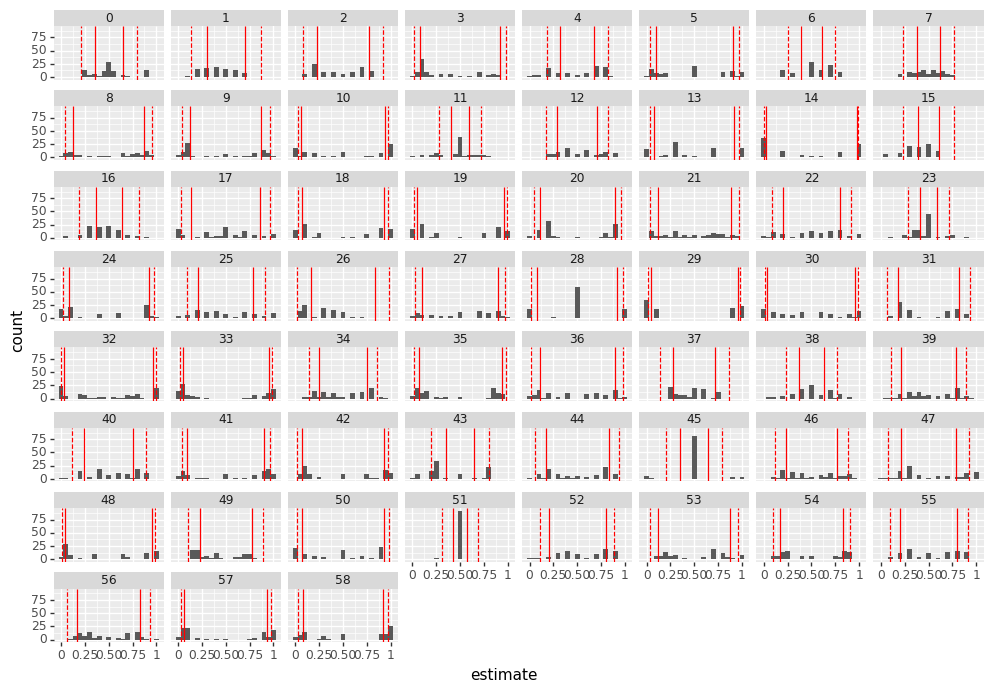

<ggplot: (8783277618511)>

In [7]:
import plotnine 
plotnine.options.figure_size = (12, 8)

post1 = posterior_to_df_mlm(model_exp1, ["k"], ["d_subj","d_prime_subj"])

(
    post1 >> 
    s.group_by(_.ID) >> 
    s.summarize(
        d  = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.025),
        d_ul = _.d_subj.quantile(.975),
    ) >>
    s.right_join(_, df1, on="ID") >>
    s.group_by(_.ID, _.querydetail) >>
    s.mutate(
        variance = _.estimate.var(),
        est_mean = _.estimate.mean(),
        est_Ninv = (_.variance / (_.est_mean*(1-_.est_mean)))
        ) >>
    # s.filter(_.est_Ninv > 0.001) >>
    # s.mutate(est_N = 1/_.est_Ninv) >>
    # s.filter(_.est_mean > .4, _.est_mean < .6) >>
    # s.filter(_.est_N < 6) >>
    ggplot(aes(x="estimate")) + 
    geom_histogram(bins=21) +
        geom_vline(aes(xintercept="d"), color="red") + 
    geom_vline(aes(xintercept="(1-d)"), color="red") + 
    geom_vline(aes(xintercept="d_ll"), color="red", linetype="dashed") + 
    geom_vline(aes(xintercept="(1-d_ll)"), color="red", linetype="dashed") + 
    facet_wrap("~ID")
)


In [8]:
(
    post1 >> 
    s.group_by(_.ID) >> 
    s.summarize(
        d  = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.025),
        d_ul = _.d_subj.quantile(.975),
    ) >>
    s.right_join(_, df1, on="ID") >>
    s.mutate(too_low = _.estimate < _.d, too_high = + _.estimate > (1-_.d), outside = _.too_low + _.too_high) >>
    s.count(_.outside)
)

,outside,n
0,False,3340
1,True,2324


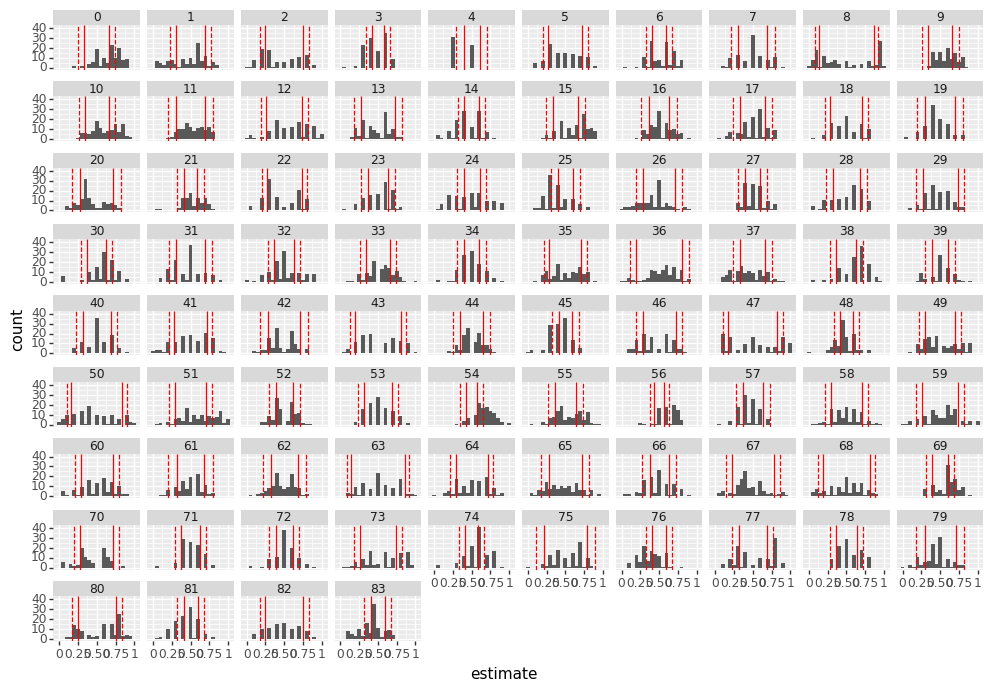

<ggplot: (8783310315162)>

In [9]:
# import matplotlib
# matplotlib.rcParams['figure.figsize'] = [8, 8]


post2 = posterior_to_df_mlm(model_exp2, ["k"], ["d_subj","d_prime_subj"])

(
    post2 >> 
    s.group_by(_.ID) >> 
    s.summarize(
        d  = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.025),
        d_ul = _.d_subj.quantile(.975),
    ) >>
    s.right_join(_, df2, on="ID") >>
    s.group_by(_.ID, _.querydetail) >>
    s.mutate(
        variance = _.estimate.var(),
        est_mean = _.estimate.mean(),
        est_Ninv = (_.variance / (_.est_mean*(1-_.est_mean)))
        ) >>
    s.filter(_.est_Ninv > 0.001) >>
    s.mutate(est_N = 1/_.est_Ninv) >>
    # s.filter(_.est_mean > .4, _.est_mean < .6) >>
    # s.filter(_.est_N < 6) >>
    ggplot(aes(x="estimate")) + 
    geom_histogram(bins=21) +
        geom_vline(aes(xintercept="d"), color="red") + 
    geom_vline(aes(xintercept="(1-d)"), color="red") + 
    geom_vline(aes(xintercept="d_ll"), color="red", linetype="dashed") + 
    geom_vline(aes(xintercept="(1-d_ll)"), color="red", linetype="dashed") + 
    facet_wrap("~ID")
)

In [10]:

(
    post2 >> 
    s.group_by(_.ID) >> 
    s.summarize(
        d  = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.025),
        d_ul = _.d_subj.quantile(.975),
    ) >>
    s.right_join(_, df2, on="ID") >>
    s.mutate(too_low = _.estimate < _.d, too_high = + _.estimate > (1-_.d), outside = _.too_low + _.too_high) >>
    s.count(_.outside)
)

,outside,n
0,False,6061
1,True,4019


Two things to look for for BS model --- 

- responses outside the predicted truncated range (present for most Ps, sometimes pretty common)---even for edge of 95% CI for truncation.
    - even for 95% CI, about 20% are out of the range in exp2! And similar number in exp 1.
- responses clumping at the d and 1-d values -- not occurring consistently, although I see some hints of it. It could occur somewhat even with my initialization scheme. Reasonable reason to assume my initialization approach is reasonable I think as I'm not seeing anythig TOO telling.